In [1]:
import numpy as np
from pathlib import Path
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms

from pmldiku import data

In [5]:
MNIST = data.load_mnist()
data_loader = MNIST.setup_data_loader()

In [3]:
data_loader = MNIST.setup_data_loader()

In [4]:
data_loader

In [16]:
batch = next(iter(data_loader))


[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         ...,
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ..

In [10]:

obs_n = 2

x, y = batch[0][obs_n], batch[1][obs_n]

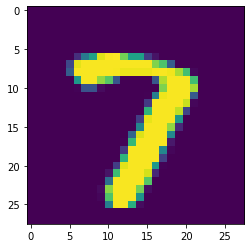

In [11]:
plt.imshow(x.squeeze().numpy())

# VAE with convolutional layers

In [22]:
cuda2 = False # torch.cuda.is_available() can be used to check if a gpu is available - I just set it to False
batch_size2 = 128
log_interval2 = 10
epochs2 = 4 # 10

torch.manual_seed(1) # args.seed

device = torch.device("cuda" if cuda2 else "cpu") # args.cuda
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda2 else {} # args.cuda

# Get train and test data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size2, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size2, shuffle=True, **kwargs)

# Define VAE model
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.conv1 = nn.Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=0)
        self.conv2 = nn.Conv2d(6, 32, kernel_size=(5, 5), stride=(2, 2), padding=0)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=0)
        self.flatten = nn.Flatten()
        self.fc21 = nn.Linear(1024, 2) # Latent space of 2D
        self.fc22 = nn.Linear(1024, 2) # Latent space of 2D
        self.fc3 = nn.Linear(2, 1024) # Latent space of 2D
        self.conv4 = nn.ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=0)
        self.conv5 = nn.ConvTranspose2d(32, 6, kernel_size=(5, 5), stride=(2, 2), padding=0)
        self.conv6 = nn.ConvTranspose2d(6, 1, kernel_size=(8, 8), stride=(1, 1), padding=0)

    def encode(self, x):
        h1 = F.relu(self.conv1(x))
        h2 = F.relu(self.conv2(h1))
        h3 = F.relu(self.conv3(h2))
        h4 = self.flatten(h3)
        return self.fc21(h4), self.fc22(h4)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std 

    def decode(self, z):
        h5 = self.fc3(z)
        h6 = h5.view(-1, 64, 4, 4)
        h7 = F.relu(self.conv4(h6))
        h8 = F.relu(self.conv5(h7))
        return torch.sigmoid(self.conv6(h8)) # Scale into 0-1 range

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD # -ELBO


def train(epoch):
    model.train() # so that everything has gradients and we can do backprop and so on...
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad() # "reset" gradients to 0 for text iteration
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch.view(-1, 784), data, mu, logvar)
        loss.backward() # calc gradients
        train_loss += loss.item()
        optimizer.step() # backpropagation

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad(): # no_grad turns of gradients...
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch.view(-1, 784), data, mu, logvar).item()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))


for epoch in range(1, epochs2 + 1):
    train(epoch)
    test(epoch)
    with torch.no_grad():
        sample = torch.randn(64, 2).to(device) # 20 -> 2
        sample = model.decode(sample).cpu()
        # save_image(sample.view(64, 1, 28, 28),
        #            'results/sample_' + str(epoch) + '.png')

====> Epoch: 1 Average loss: 214.9457
====> Test set loss: 172.1558
====> Epoch: 2 Average loss: 168.7621
====> Test set loss: 166.0689
====> Epoch: 3 Average loss: 163.6073
====> Test set loss: 161.9800
====> Epoch: 4 Average loss: 160.3810
====> Test set loss: 159.2932


In [30]:
mnist_test = list(test_loader)
B = len(mnist_test)
results = torch.zeros((128*B,2))
all_labels = torch.empty(0)
l = 0
for b in range(B):
    labels = mnist_test[b][1]
    all_labels = torch.cat((all_labels, labels))
    
    images = mnist_test[b][0]
    K = images.shape[0]
    for k in range(K):
        an_img = images[k,:,:,:]
        # an_img_flat = torch.flatten(an_img)
        mean_img = model.encode(an_img.view(1, 1, 28, 28))[0]
        results[l] = mean_img
        l +=1
results = results[:l,:]
all_labels = all_labels[:l]

c:\Users\Juliu\anaconda3\envs\OreL\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


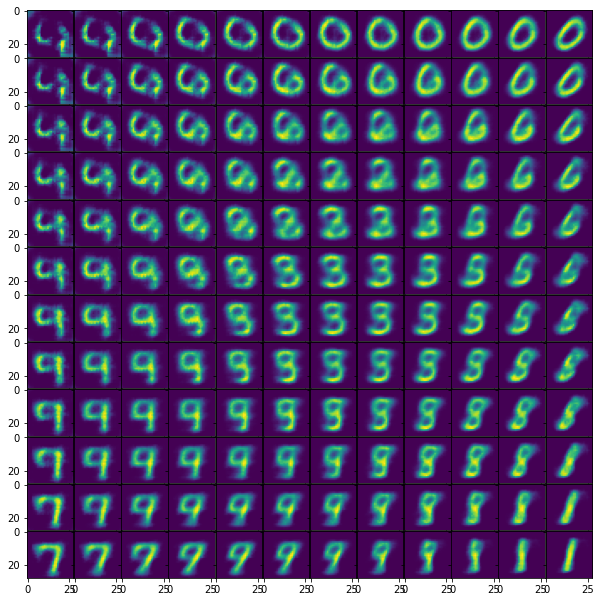

In [31]:
M = 12
x = torch.linspace(start=0, end=1, steps=M+2)
x = x[:-1]
x = x[1:]

mesh_x, mesh_y = torch.meshgrid(x, x)
gauss = torch.distributions.normal.Normal(loc = 0, scale = 1)
gauss_x = gauss.icdf(mesh_x)#.flip(0)
gauss_y = gauss.icdf(mesh_y)

fig, ax = plt.subplots(nrows=M, ncols=M, figsize=(8, 8), sharex = True, sharey = True)
for i in range(M):
    for j in range(M):
        x_val = gauss_x[i,j].item()
        y_val = gauss_y[i,j].item()
        im = model.decode(torch.Tensor([y_val, x_val]))
        im_plt = im.reshape((28,28))
        plot_me = im_plt.detach().numpy()
        ax[i,j].imshow(plot_me)

slim=0.6
plt.tight_layout(pad=-slim, w_pad=-slim, h_pad=-slim)
plt.show()